# Power Analysis

Power calculations help determine the necessary sample size, power, or minimum detectable effect size (MDES) for randomized control trials (RCTs). 

How can we use power calculations?

1. **Sample Size**: Calculate the required sample size to detect a specific effect size with a given power level.
2. **Power**: Evaluate the power of a study given its sample size and MDES.
3. **Effect Size**: Determine the smallest effect size that can be detected with a given sample size and power level. Given that I only have budget to sample $x$ households, what is the minimum effect size that I will be able to distinguish from a null effect? 

What is power? It is the "ability" of an experiment to detect a statistically significant difference. In statistical terms, it is the probability of correctly rejecting the null hypothesis when it is false. Power calculations balance statistical precision with resource costs

What is MDES? The minimum detectable effect size is the effect size set by the researcher that an experiment is designed to estimate for a given level of significance. To set the minimum detectable effect, consider the change in outcomes that would justify the investment in an intervention.

More info:
- [Power Calculations - World Bank](https://dimewiki.worldbank.org/Power_Calculations)
- [Statistical Power Analysis in Python](https://statsthinking21.github.io/statsthinking21-python/09-StatisticalPower.html)
- [Introduction to Power Analysis in Python](https://towardsdatascience.com/introduction-to-power-analysis-in-python-e7b748dfa26)


In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import statsmodels.stats.power as smp
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "retina"

## Sample Size Calculation

To calculate sample size with power calculations, you need to know the MDES, the standard deviation of the population outcome, and the Type I and Type II significance levels.

As power is typically set at 0.80, you may ask yourself:
- Given that I want to be able to statistically distinguish program impact of a 10% change in my outcome of interest, what is the minimum **sample size** needed?

Parameters to consider when using `statsmodels` for sample size calculation:
- `effect_size`: standardized effect size, which is the difference between the two means divided by the standard deviation
- `power`: desired power level (typically 0.80), which is one minus the probability of a type II error
- `alpha`: significance level (typically 0.05), which is the probability of a type I error

**Clarification:** If a researcher sets MDES to 10%, for example, they may not be able to distinguish a 7% increase in income from a null effect. To be clear, MDES is not the effect size we expect or want. However, to select MDES, it is important to consider the expected effect size. For example, if a program is expected to raise incomes by a minimum of 10%, it may not be necessary to have the option to distinguish program impacts of less than 10% from a null effect.

In [3]:
power_analysis = smp.TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=0.1, power=0.8, alpha=0.05)
print(f"Sample size needed: {sample_size:.0f}")

Sample size needed: 1571


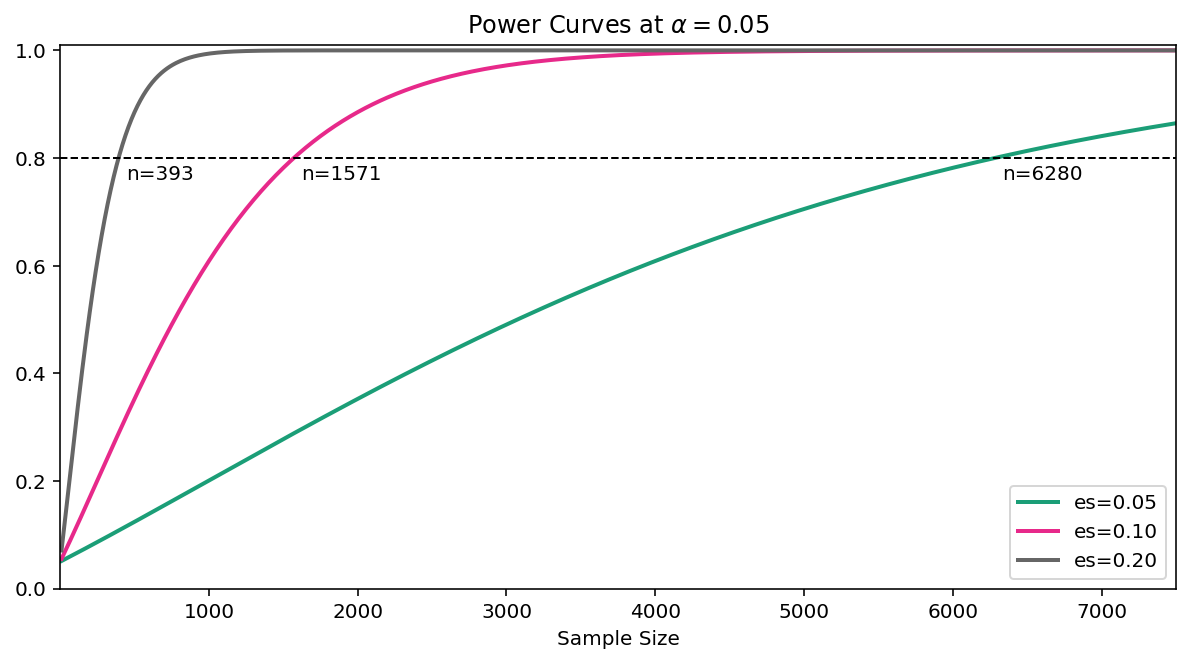

In [5]:
effect_sizes = np.array([0.05, 0.1, 0.2])
sample_sizes = np.array(range(10, 7500, 10))

# Plot the power curves
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
fig = power_analysis.plot_power(dep_var='nobs', nobs=sample_sizes,
                                effect_size=effect_sizes, alpha=0.05, ax=ax,
                                title='Power Curves at $\\alpha = 0.05$')

# Add a horizontal line for the desired power level 0.8
ax.axhline(y=0.8, color='k', linestyle='--', linewidth=1)

# Add text for the sample sizes needed for each effect size at power 0.8
for effect_size in effect_sizes:
    n = power_analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05)
    ax.annotate(f'n={n:.0f}', xy=(n, 0.8), xytext=(n+50, 0.76))

# Change x and y limits to make the plot more readable
plt.xlim(1, 7500)
plt.ylim(0, 1.01)
plt.xlabel('Sample Size')
plt.show()

## Effect Size Calculation

As power is typically set at 0.80, power calculations are usually used to compute either sample size or MDES. When deciding which to estimate, consider the research design and constraints of a specific evaluation. You may ask yourself:
- Given that I only have budget to sample 1,000 households, what is the minimum effect size that I will be able to distinguish from a null effect?

In [6]:
mdes = power_analysis.solve_power(power=0.8, alpha=0.05, nobs1=1000)
print(f"Minimum detectable effect size (MDES) for n=1000: {mdes:.3f}")

Minimum detectable effect size (MDES) for n=1000: 0.125


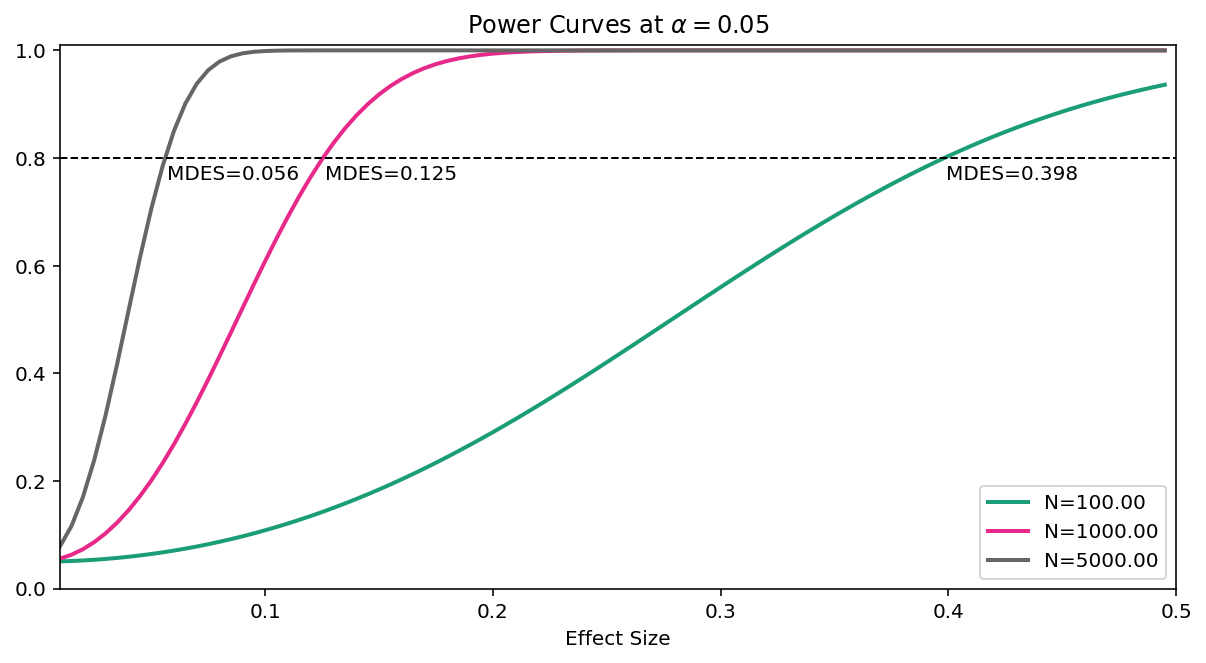

In [7]:
sample_sizes = np.array([100, 1000, 5000])
effect_sizes = np.arange(0.01, 0.5, 0.005)

# Plot the power curves
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
fig = power_analysis.plot_power(dep_var='effect_size', nobs=sample_sizes,
                                effect_size=effect_sizes, alpha=0.05, ax=ax,
                                title='Power Curves at $\\alpha = 0.05$')

# Add a horizontal line for the desired power level 0.8
ax.axhline(y=0.8, color='k', linestyle='--', linewidth=1)

# Add text for the minimum detectable effect size for each sample size at power 0.8
for sample_size in sample_sizes:
    mdes = power_analysis.solve_power(power=0.8, alpha=0.05, nobs1=sample_size)
    ax.annotate(f'MDES={mdes:.3f}', xy=(mdes, 0.8), xytext=(mdes+0.001, 0.76))

# Change x and y limits to make the plot more readable
plt.xlim(0.01, 0.5)
plt.ylim(0, 1.01)
plt.xlabel('Effect Size')
plt.show()

## Simulating statistical power

We can also simulate data to see whether the power analysis actually gives the right answer. We will sample data for two groups, with a difference of 0.5 standard deviations between their underlying distributions and a sample size based on power analysis, and we will then look at how often we reject the null hypothesis.

In [8]:
rng = np.random.default_rng(42)

# Perform power analysis to get sample size and round up
effect_size = 0.5
sample_size = power_analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05)
sample_size = int(np.ceil(sample_size))

# Function to perform t-test on random data
def get_t_result(sample_size, effect_size):
    group_control = rng.normal(0, 1, sample_size)
    group_treat = rng.normal(effect_size, 1, sample_size)
    tresult = stats.ttest_ind(group_control, group_treat)
    return(tresult.pvalue)

In [10]:
# Simulate power
nsim = 5000
power_sim_results = pd.DataFrame({'p_value': np.zeros(nsim)})

for run in range(nsim):
    power_sim_results.loc[run, 'p_value'] = get_t_result(sample_size, effect_size)

p_reject = np.mean(power_sim_results['p_value'] < 0.05)
print(f"Simulated power: {p_reject:.3f}")

Simulated power: 0.806
